In [1]:
import pandas as pd

names_data = pd.read_csv('datasets/gender_by_names/names.csv')

names_data.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [2]:
len(names_data)

10132

In [6]:
len(names_data['Name'].unique())

9543

In [8]:
import random

names_data = names_data.drop_duplicates(subset=['Name'], keep=random.choice(['first', 'last']))

In [9]:
len(names_data)

9543

In [10]:
names_data.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [11]:
from sklearn import preprocessing

In [12]:
le = preprocessing.LabelEncoder()
names_data['Gender'] = le.fit_transform(names_data['Gender'])
names_data.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [13]:
genders = ['Female', 'Male']

In [14]:
import string
all_letters = string.ascii_letters + " .,;'"

In [15]:
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [16]:
import torch

def name_to_tensor(name):
    name_in_tensor = torch.zeros(len(name), 1, n_letters)
    for i, letter in enumerate(name):
        name_in_tensor[i][0][all_letters.find(letter)] = 1
        
    return name_in_tensor

In [17]:
name_to_tensor('a')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [18]:
name_to_tensor('aA')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [20]:
n_hidden = 128
n_genders = len(genders)

rnn = RNN(n_letters, n_hidden, output_size = n_genders)

In [21]:
iterations = 100000

criterion = nn.NLLLoss()

learning_rate = 0.005

In [22]:
def output_to_gender(output):
    top_n, top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = genders[pred_i]
    
    return pred

In [23]:
import random

In [24]:
for iteration in range(1, iterations + 1):
    
    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender])
    
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[i], hidden)
    
    loss = criterion(output, gender_in_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    if iteration% 5000 == 0:
        pred = output_to_gender(output)
        correct = 'Y' if pred == genders[gender] else 'N (%s)' % genders[gender]
        print('iters- %d %d%% (%s) Name- %s Gender- %s %s' % (iteration, iteration/iterations*100, loss.item(), name, pred, correct))

iters- 5000 5% (0.7001264691352844) Name- Magaly Gender- Male N (Female)
iters- 10000 10% (0.3311519920825958) Name- Mohamad Gender- Male Y
iters- 15000 15% (0.30288660526275635) Name- Carlynn Gender- Female Y
iters- 20000 20% (0.007616758346557617) Name- Rasheeda Gender- Female Y
iters- 25000 25% (0.8367712497711182) Name- Beatrice Gender- Male N (Female)
iters- 30000 30% (0.009732723236083984) Name- Michelina Gender- Female Y
iters- 35000 35% (0.19788998365402222) Name- Bobbette Gender- Female Y
iters- 40000 40% (0.23715358972549438) Name- Raine Gender- Female Y
iters- 45000 45% (0.5699573755264282) Name- Deshawn Gender- Male Y
iters- 50000 50% (1.8522062301635742) Name- Sloane Gender- Female N (Male)
iters- 55000 55% (0.034534454345703125) Name- Sherwood Gender- Male Y
iters- 60000 60% (2.7122182846069336) Name- Vassili Gender- Female N (Male)
iters- 65000 65% (0.2923753261566162) Name- Fox Gender- Male Y
iters- 70000 70% (0.281310498714447) Name- Zackariah Gender- Male Y
iters- 750

In [25]:
n_confusion = 10000

prediction = []
actual = []

for _ in range(n_confusion):
    
    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender_idx = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender_idx])
    
    hidden = rnn.initHidden()
    
    for j in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[j], hidden)
        
    pred = output_to_gender(output)
    
    prediction.append(pred)
    actual.append(genders[gender_idx])

In [26]:
!pip install pandas_ml

  Running setup.py bdist_wheel for pandas-ml: started
  Running setup.py bdist_wheel for pandas-ml: finished with status 'done'
  Stored in directory: C:\Users\isuru\AppData\Local\pip\Cache\wheels\4b\b0\88\51fb7203a0f81becae3e92d5bf9fee0460375e5408e67a7dc3
Successfully built pandas-ml


In [27]:
from pandas_ml import ConfusionMatrix
import numpy as np

In [28]:
np_prediction = np.array(prediction)
np_actual = np.array(actual)

In [29]:
cm = ConfusionMatrix(np.where(np_prediction == 'Female', True, False), np.where(np_actual == 'Female', True, False))

cm

Predicted  False  True  __all__
Actual                         
False       2301   733     3034
True        1022  5944     6966
__all__     3323  6677    10000

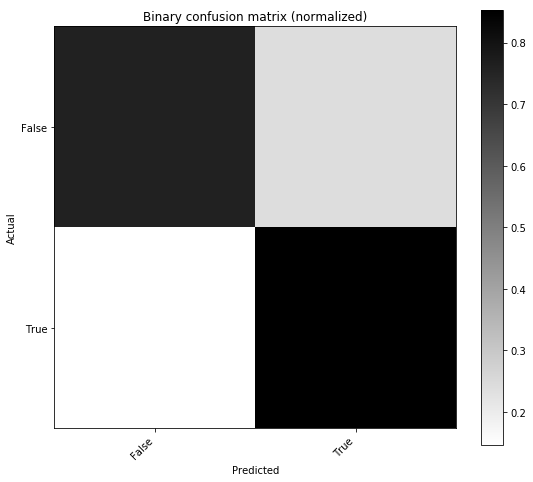

In [31]:
import matplotlib.pyplot as plt
cm.plot(normalized=True)
plt.show()